In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from dslab import adguide #source: https://github.com/adophobr/PhotonicIntegratedCircuits/blob/main/jupyter/utils/dslab.py
import warnings
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python')
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')
from scipy.constants import c

Units

In [2]:
um = 1e-6
nm = 1e-9

In [3]:
warnings.filterwarnings("ignore", category=SyntaxWarning)
import lumapi
fdtdApi = lumapi.FDTD()

Materials

In [4]:
materialClad = "SiO2 (Glass) - Dispersive & Lossless"
materialSi = "Si (Silicon) - Dispersive & Lossless"

# Add material
matname = materialSi

fdtdApi.addmaterial("Lorentz")
fdtdApi.setmaterial('New material 1', "Name", matname)
fdtdApi.setmaterial(matname, "Permittivity", 7.9837492)
fdtdApi.setmaterial(matname, "Lorentz Linewidth", 1e8)
fdtdApi.setmaterial(matname, "Lorentz Resonance", 3.93282466e+15)
fdtdApi.setmaterial(matname, "Lorentz Permittivity", 3.68799143)
fdtdApi.setmaterial(matname, "color", np.array([0.85, 0, 0, 1])) # red

In [5]:
matname = materialClad
fdtdApi.addmaterial("Lorentz")
fdtdApi.setmaterial('New material 1', "Name", matname)
fdtdApi.setmaterial(matname, "Permittivity", 2.119881)
fdtdApi.setmaterial(matname, "Lorentz Linewidth", 1e10)
fdtdApi.setmaterial(matname, "Lorentz Resonance", 3.309238e+13)
fdtdApi.setmaterial(matname, "Lorentz Permittivity", 49.43721)
fdtdApi.setmaterial(matname, "color", np.array([0.5, 0.5, 0.5, 1])) # grey

Dimensions

In [6]:
Wm = 7*um
L  = 61*um #obtained via EME and varFDTD simulations
#tapers
taper_large_tip = 1.5 * um
taper_length = 15 * um
#slabs 
width = 450 * nm
height = 220 * nm
length = 5 * um
cband = True

nr = 3.476  # wl @1550nm
nc = 1.444  # wl @1550nm
lambda0 = 1550 * nm
k0 = 2 * np.pi / lambda0
sigmaTE = 0  #ref: soldano
sigmaTM = 1  #ref: soldano
We = Wm + (lambda0 / np.pi) * ((nc / nr) ** (2 * sigmaTE)) * ((nr ** 2 - nc ** 2) ** (-0.5))


# C band simulation: 1520 ~ 1575 nm
# L band simulation: 1555 ~ 1635 nm
if cband:
    wl_start = 1520 * nm
    wl_stop = 1575 * nm
else:
    wl_start = 1555 * nm
    wl_stop = 1635 * nm


In [7]:
fdtdApi.switchtolayout()
fdtdApi.deleteall()
fdtdApi.cleardcard

<bound method Lumerical.__init__.<locals>.<lambda>.<locals>.<lambda> of <lumapi.FDTD object at 0x00000181F5EAB470>>

In [8]:
fdtdApi.addstructuregroup()
dev_layer = 'GDS_LAYER_35:4'
fdtdApi.set('name', dev_layer)
filename = 'FDTD_mmi_2x2_TE.dat'

Box

In [9]:
fdtdApi.addrect()
fdtdApi.addtogroup(dev_layer)
fdtdApi.set('name','box')
fdtdApi.set('x',0)
fdtdApi.set('x span', L)
fdtdApi.set('y',0)
fdtdApi.set('y span', Wm)
fdtdApi.set('z',height/2)
fdtdApi.set('z span', height)
fdtdApi.set('material', materialSi)

Tapers

In [10]:
for i in range(4):
    fdtdApi.addobject('linear_taper')
    fdtdApi.set('name', f'taper port {str(i+1)}')
    fdtdApi.set('thickness', height)
    fdtdApi.set('angle_side', 90)
    fdtdApi.set('width_l', width)
    fdtdApi.set('width_r', taper_large_tip)
    fdtdApi.set('len', taper_length)
    fdtdApi.set('material', materialSi)
    fdtdApi.set('x', -(fdtdApi.getnamed(f'{dev_layer}::box', 'x max') + taper_length/2))
    fdtdApi.set('y', Wm/6)
    fdtdApi.set('z', height/2)

In [11]:
#adjusting port 2
fdtdApi.select(f'{dev_layer}::taper port 2')
fdtdApi.set('width_l', taper_large_tip)
fdtdApi.set('width_r', width)
fdtdApi.set('x', fdtdApi.getnamed(f'{dev_layer}::box', 'x max') + taper_length/2)
fdtdApi.set('y', Wm/6)

##adjusting port 3
fdtdApi.select(f'{dev_layer}::taper port 3')
fdtdApi.set('width_l', taper_large_tip)
fdtdApi.set('width_r', width)
fdtdApi.set('x', fdtdApi.getnamed(f'{dev_layer}::box', 'x max') + taper_length/2)
fdtdApi.set('y', -Wm/6)
#adjusting port 4

fdtdApi.select(f'{dev_layer}::taper port 4')
fdtdApi.set('y', -Wm/6)

Waveguides

In [12]:
for i in range(4):
    fdtdApi.addrect()
    fdtdApi.addtogroup(dev_layer)
    fdtdApi.set('name', f'port {str(i+1)}')
    fdtdApi.set('x', -(fdtdApi.getnamed(f'{dev_layer}::box', 'x max') + taper_length + length/2))
    fdtdApi.set('x span', length)
    fdtdApi.set('y', Wm/6)
    fdtdApi.set('y span', width)
    fdtdApi.set('z', height/2)
    fdtdApi.set('z span', height)
    fdtdApi.set('material', materialSi)

In [13]:
#adjusting
fdtdApi.select(f'{dev_layer}::port 2')
fdtdApi.set('x', (fdtdApi.getnamed(f'{dev_layer}::box', 'x max') + taper_length + length/2))

fdtdApi.select(f'{dev_layer}::port 3')
fdtdApi.set('x', (fdtdApi.getnamed(f'{dev_layer}::box', 'x max') + taper_length + length/2))
fdtdApi.set('y', -Wm/6)

fdtdApi.select(f'{dev_layer}::port 4')
fdtdApi.set('y',-Wm/6)

Adding solver

In [14]:
#simulation time
simulation_time = 2*(L + 2*length + 2*taper_length)/(3e8/3.476)
#position
x_FDTD = 0
y_FDTD = 0
z_FDTD = 0
#span
x_span_FDTD = (L + 2*taper_length + 2*length)*1.05
y_span_FDTD = Wm + 0.25*Wm
z_span_FDTD = 1*um
#material
background_material = materialClad
nmbFrqPts = 20
mesh_accuracy = 3

In [15]:
#ports parameters
y_port_off = 0.5*um

x_span_port = 4*um
z_span_port = 1*um
#ports positions
x_ports_positions = np.array([-(L/2 + taper_length + length/2),-(L/2 + taper_length + length/2)])
y_ports_positions = np.array([Wm/6, -Wm/6])
mode_selection = 'fundamental TE mode'
injection_axis = 'x-axis'

Solver

In [16]:
fdtdApi.addfdtd()

In [17]:
fdtdApi.set('simulation time', simulation_time) #
fdtdApi.set('x', x_FDTD)
fdtdApi.set('x span',x_span_FDTD)
fdtdApi.set('y', y_FDTD)
fdtdApi.set('y span',y_span_FDTD)
fdtdApi.set('z', z_FDTD)
fdtdApi.set('z span',z_span_FDTD)
fdtdApi.set('background material', background_material)
fdtdApi.set('mesh accuracy', mesh_accuracy)
#boundary conditions
fdtdApi.set('x min bc', 'PML')
fdtdApi.set('x max bc', 'PML')
fdtdApi.set('y min bc', 'PML')
fdtdApi.set('y max bc', 'PML')
fdtdApi.set('z min bc', 'Symmetric')
fdtdApi.set('z max bc', 'PML')
fdtdApi.set('PML type', 'stretched coordinate PML')
fdtdApi.set('PML profile', 1)

'''#more stability (just use if it's not converging 
fdtdApi.set('dt stability factor', 0.99)
#custom PML setup
fdtdApi.set('PML type', 'stretched coordinate PML')
fdtdApi.set('PML profile', 4)
fdtdApi.set('PML layers', 40)
fdtdApi.set('PML kappa', 10)
fdtdApi.set('PML sigma', 1)
fdtdApi.set('PML alpha', 10))'''

"#more stability (just use if it's not converging \nfdtdApi.set('dt stability factor', 0.99)\n#custom PML setup\nfdtdApi.set('PML type', 'stretched coordinate PML')\nfdtdApi.set('PML profile', 4)\nfdtdApi.set('PML layers', 40)\nfdtdApi.set('PML kappa', 10)\nfdtdApi.set('PML sigma', 1)\nfdtdApi.set('PML alpha', 10))"

Ports

In [18]:
for i in range(2):
    fdtdApi.addmode()
    fdtdApi.set('name', f'port {str(i+1)}')
    fdtdApi.set('injection axis', injection_axis)
    fdtdApi.set('mode selection', mode_selection)
    fdtdApi.set('x', x_ports_positions[i])
    fdtdApi.set('y', y_ports_positions[i])
    fdtdApi.set('z', height/2)
    fdtdApi.set('y span', 2*um)
    fdtdApi.set('z span', z_span_port)
    fdtdApi.set('wavelength start', wl_start)
    fdtdApi.set('wavelength stop', wl_stop)

In [19]:
fdtdApi.addprofile()
fdtdApi.set('override global monitor settings', True)
fdtdApi.set('frequency points', nmbFrqPts)
fdtdApi.set('x', x_FDTD)
fdtdApi.set('x span', x_span_FDTD)
fdtdApi.set('y', y_FDTD)
fdtdApi.set('y span', y_span_FDTD)
fdtdApi.set('z', 0)


In [20]:
# input field profile
for i in range(2):
    fdtdApi.addprofile()
    fdtdApi.set('name', f'input profile {i+1}')
    fdtdApi.set('monitor type', '2D X-normal')
    fdtdApi.set('x', x_ports_positions[i])
    fdtdApi.set('y',Wm/6)
    fdtdApi.set('y span', 2*um)
    fdtdApi.set('z',height/2)
fdtdApi.select('input profile 1')
fdtdApi.set('y',-Wm/6)

In [21]:
#output fields profiles
#port 2
for i in range(2):
    fdtdApi.addprofile()
    fdtdApi.set('name', f'output profile port {i+2}')
    fdtdApi.set('monitor type', '2D X-normal')
    fdtdApi.set('x', (L/2 + taper_length))
    fdtdApi.set('y',Wm/6)
    fdtdApi.set('y span', 2*um)
fdtdApi.select('output profile port 3')
fdtdApi.set('y',-Wm/6)


In [22]:
fdtdApi.setnamed('FDTD','global source wavelength start', wl_start)
fdtdApi.setnamed('FDTD','global source wavelength stop', wl_stop)
#fdtdApi.setnamed('FDTD::ports','monitor frequency points',nmbFrqPts)

In [23]:
fdtdApi.save(filename)

In [24]:
fdtdApi.run(3)

In [25]:
#field profile
E = fdtdApi.getresult('monitor', 'E')

x = E['x']
x = x[:,0]/um
y = E['y']
y = y[:,0]/um
z = E['z']  

E = E['E']

Ex = E[:,:,0,:,0]
Ey = E[:,:,0,:,1]
Ez = E[:,:,0,:,2]

Emag = np.sqrt(np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2)

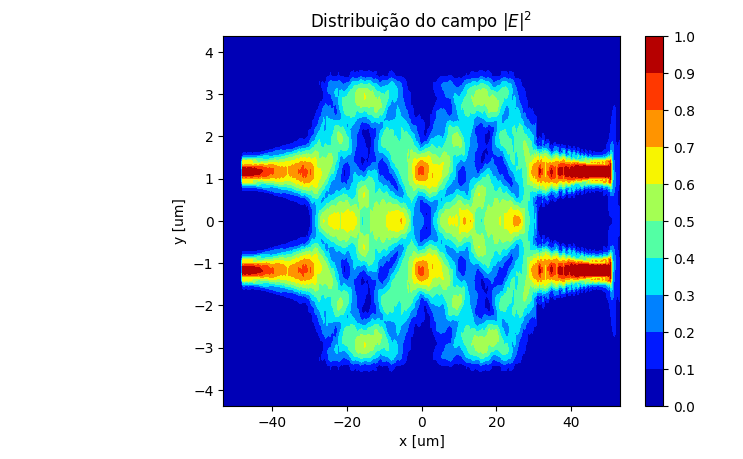

In [26]:
plt.figure()
mycmap = plt.get_cmap('jet')

v = np.linspace(0, 1, 11, endpoint=True)

plt.contourf(x,y,np.transpose(Emag[:,:,0]), v, cmap=mycmap)
plt.colorbar(ticks=v)
plt.title(r'Distribuição do campo $|E|^2$', fontsize = 12)
plt.ylabel('y [um]', fontsize = 10)
plt.xlabel('x [um]', fontsize = 10)

plt.text(-110,4, 'Porta 1', fontsize = 12, fontweight = 'bold', color='w')
plt.text(65,4,'Porta 2', fontsize = 12, fontweight = 'bold', color='w')
plt.text(65,-4,'Porta 3', fontsize = 12, fontweight = 'bold', color='w')
plt.text(-110,-4, 'Porta 4', fontsize = 12, fontweight = 'bold', color='w')
plt.savefig('Distribuição do campo E FDTD')

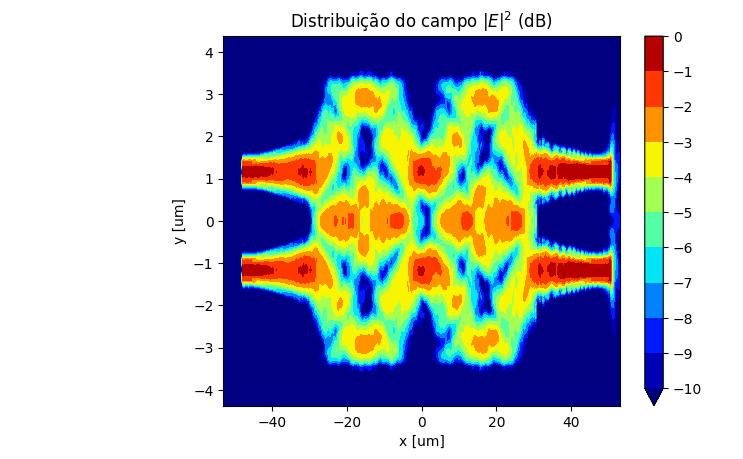

In [27]:
plt.figure()
#mycmap = plt.get_cmap('jet')

v = np.linspace(-10, 0, 11, endpoint=True)

CS = plt.contourf(x,y,10*np.log10(np.transpose(Emag[:,:,0])), v, cmap=mycmap, extend='min')
plt.colorbar(ticks=v)

plt.title(r'Distribuição do campo $|E|^2$ (dB)', fontsize = 12)
plt.ylabel('y [um]', fontsize = 10)
plt.xlabel('x [um]', fontsize = 10)

plt.text(-110,4, 'Porta 1', fontsize = 12, fontweight = 'bold', color='w')
plt.text(65,4,'Porta 2', fontsize = 12, fontweight = 'bold', color='w')
plt.text(65,-4,'Porta 3', fontsize = 12, fontweight = 'bold', color='w')
plt.text(-110,-4, 'Porta 4', fontsize = 12, fontweight = 'bold', color='w')
plt.savefig('Distribuição do campo E (db) FDTD')

In [28]:
Tin   = fdtdApi.getresult('input profile 1', 'T')
Tout2 = fdtdApi.getresult('output profile port 2', 'T')
Tout3 = fdtdApi.getresult('output profile port 3', 'T')

T1 = np.abs(Tin['T'])**2
T2 = np.abs(Tout2['T'])**2
T3 = np.abs(Tout3['T'])**2

T1_dB = 10*np.log10(T1)
T2_dB = 10*np.log10(T2)
T3_dB = 10*np.log10(T3)

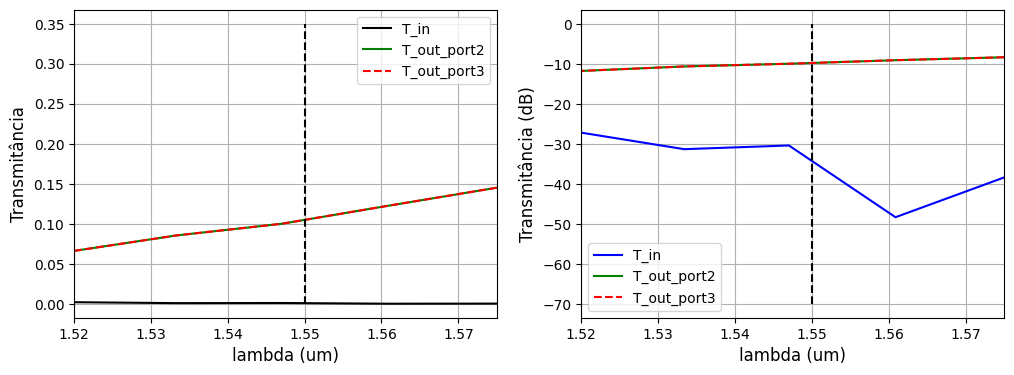

In [29]:
fig, axs = plt.subplots(1,2, figsize = (12,4))

axs[0].plot(Tin['lambda']/um, T1, 'black', lw=1.5, label='T_in')
axs[0].plot(Tin['lambda']/um, T2, 'g', lw=1.5, label='T_out_port2')
axs[0].plot(Tin['lambda']/um, T3, 'r--', lw=1.5, label='T_out_port3')
axs[0].plot(1.55*np.ones(5), np.linspace(0,0.35,5), lw=1.5, linestyle='--', color='k')
axs[0].set_xlabel('lambda (um)', fontsize = 12)
axs[0].set_ylabel('Transmitância', fontsize = 12)
axs[0].set_xlim([wl_start/um,wl_stop/um])
#axs[0].set_ylim([0,0.55])
axs[0].legend()
axs[0].grid(True)

axs[1].plot(Tin['lambda']/um, T1_dB, 'b', lw=1.5, label='T_in')
axs[1].plot(Tin['lambda']/um, T2_dB, 'g', lw=1.5, label='T_out_port2')
axs[1].plot(Tin['lambda']/um, T3_dB, 'r--', lw=1.5, label='T_out_port3')
axs[1].plot(1.55*np.ones(5), np.linspace(-70,0,5), lw=1.5, linestyle='--', color='k')
axs[1].set_xlabel('lambda (um)', fontsize = 12)
axs[1].set_ylabel('Transmitância (dB)', fontsize = 12)
axs[1].set_xlim([wl_start/um,wl_stop/um])
#axs[1].set_ylim([-30,-10])
axs[1].legend()
axs[1].grid(True)
plt.savefig('transmitancia fdtd')

In [30]:
#setup to export S params
'''#ports positions
x_ports_positions = np.array([-(L / 2 + taper_length + length / 2), (L / 2 + taper_length + length / 2),
                            (L / 2 + taper_length + length / 2), -(L / 2 + taper_length + length / 2)])
y_ports_positions = np.array([Wm / 6, Wm/6, -Wm/6, -Wm/6])
mode_selection = 'fundamental TE mode'
for i in range(4):
    fdtdApi.addport()
    fdtdApi.set('x', x_ports_positions[i])
    fdtdApi.set('y', y_ports_positions[i])
    fdtdApi.set('y span', 2*um)
    fdtdApi.set('z span', 1*um)'''

"#ports positions\nx_ports_positions = np.array([-(L / 2 + taper_length + length / 2), (L / 2 + taper_length + length / 2),\n                            (L / 2 + taper_length + length / 2), -(L / 2 + taper_length + length / 2)])\ny_ports_positions = np.array([Wm / 6, Wm/6, -Wm/6, -Wm/6])\nmode_selection = 'fundamental TE mode'\nfor i in range(4):\n    fdtdApi.addport()\n    fdtdApi.set('x', x_ports_positions[i])\n    fdtdApi.set('y', y_ports_positions[i])\n    fdtdApi.set('y span', 2*um)\n    fdtdApi.set('z span', 1*um)"

In [31]:
fdtdApi.switchtolayout()

In [32]:
#boundary conditions
fdtdApi.select('FDTD')
fdtdApi.set('x min bc', 'PML')
fdtdApi.set('x max bc', 'PML')
fdtdApi.set('y min bc', 'PML')
fdtdApi.set('y max bc', 'PML')
fdtdApi.set('z min bc', 'Anti-Symmetric')
fdtdApi.set('z max bc', 'PML')

In [33]:
fdtdApi.save('MMI-FDTD')

In [34]:
fdtdApi.run(3)

In [35]:
#field profile
E = fdtdApi.getresult('monitor', 'E')

x = E['x']
x = x[:,0]/um
y = E['y']
y = y[:,0]/um
z = E['z']  

E = E['E']

Ex = E[:,:,0,:,0]
Ey = E[:,:,0,:,1]
Ez = E[:,:,0,:,2]

Emag = np.sqrt(np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2)

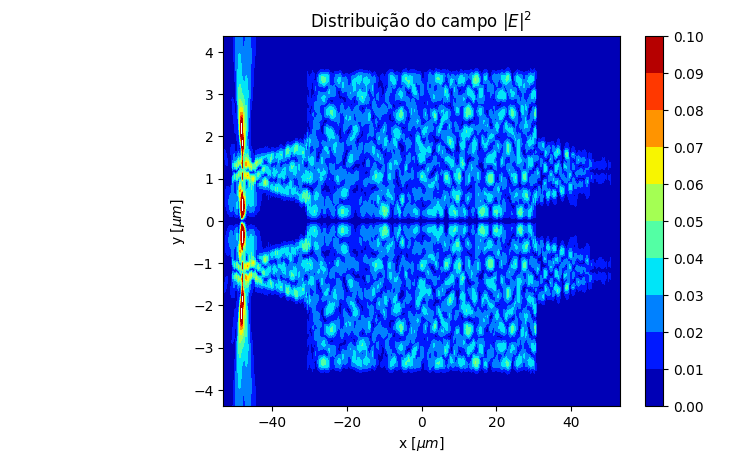

In [46]:
plt.figure()
mycmap = plt.get_cmap('jet')

v = np.linspace(0, 0.1, 11, endpoint=True)

plt.contourf(x,y,np.transpose(Emag[:,:,0]), v, cmap=mycmap)
plt.colorbar(ticks=v)
plt.title(r'Distribuição do campo $|E|^2$', fontsize = 12)
plt.ylabel(r'y $[\mu m]$', fontsize = 10)
plt.xlabel(r'x $[\mu m]$', fontsize = 10)

plt.text(-110,4, 'Porta 1', fontsize = 12, fontweight = 'bold', color='w')
plt.text(65,4,'Porta 2', fontsize = 12, fontweight = 'bold', color='w')
plt.text(65,-4,'Porta 3', fontsize = 12, fontweight = 'bold', color='w')
plt.text(-110,-4, 'Porta 4', fontsize = 12, fontweight = 'bold', color='w')
plt.savefig('Distribuição do campo E FDTD db')

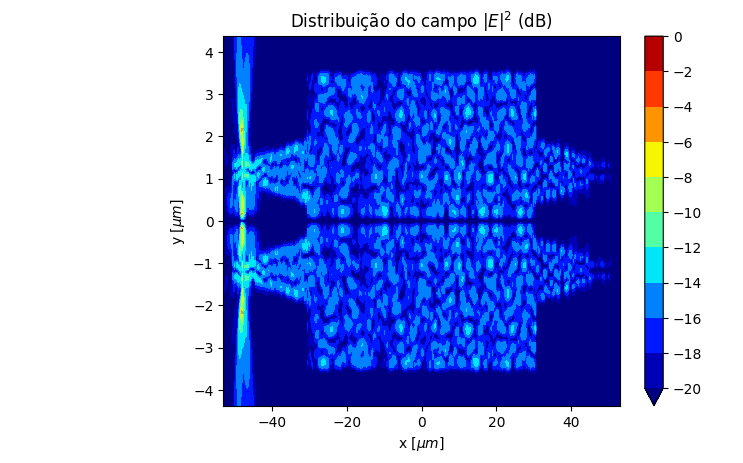

In [37]:
plt.figure()
#mycmap = plt.get_cmap('jet')

v = np.linspace(-20, 0, 11, endpoint=True)

CS = plt.contourf(x,y,10*np.log10(np.transpose(Emag[:,:,0])), v, cmap=mycmap, extend='min')
plt.colorbar(ticks=v)

plt.title(r'Distribuição do campo $|E|^2$ (dB)', fontsize = 12)
plt.ylabel(r'y $[\mu m]$', fontsize = 10)
plt.xlabel(r'x $[\mu m]$', fontsize = 10)

plt.text(-110,4, 'Porta 1', fontsize = 12, fontweight = 'bold', color='w')
plt.text(65,4,'Porta 2', fontsize = 12, fontweight = 'bold', color='w')
plt.text(65,-4,'Porta 3', fontsize = 12, fontweight = 'bold', color='w')
plt.text(-110,-4, 'Porta 4', fontsize = 12, fontweight = 'bold', color='w')
plt.savefig('Distribuição do campo E (db)  FDTD')

In [38]:
fdtdApi.switchtolayout()
fdtdApi.close()